In [1]:
from __future__ import print_function
%matplotlib inline

from sklearn import cluster
import histomicstk as htk

import numpy as np
import scipy as sp

import skimage.io
import skimage.measure
import skimage.color


import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import cv2
import numpy as np
import math

#Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 15, 15
plt.rcParams['image.cmap'] = 'gray'
titlesize = 24

In [2]:
def circle_fit(x_coords,y_coords,pixel_len):
    # Pre-processing for Circle Fitting Algorithm for Histological objects
    x1 = np.array(x_coords) # Array of x-coordinates 
    y1 = np.array(y_coords) # Array of y-coordinates

    # Apply transformation on x,y co-ordinates
    x2 = x1.reshape(1, pixel_len)
    y2 = y1.reshape(1, pixel_len)

    # Mean value of x co-ordinates
    sum_x=0
    for i in range(pixel_len):
        sum_x=sum_x+x2[0,i]
    x_mean=sum_x/(pixel_len -1)

    # Mean value of y co-ordinates
    sum_y=0
    for i in range(pixel_len):
        sum_y=sum_y+y2[0,i]
    y_mean=sum_y/(pixel_len - 1)
    
    # Circle Fitting Algorithm using linear algebra    
    u=[]
    v=[]
    Suv  = 0
    Suu  = 0
    Svv  = 0
    Suuv = 0
    Suvv = 0
    Suuu = 0
    Svvv = 0

    # calculation of the reduced coordinates
    for i in range(pixel_len):
            u.append((x2[0,i] - x_mean))
            v.append((y2[0,i] - y_mean))

    # linear system defining the center (uc, vc) in reduced coordinates:
    #    Suu * uc +  Suv * vc = (Suuu + Suvv)/2
    #    Suv * uc +  Svv * vc = (Suuv + Svvv)/2
    for i in range(pixel_len):
        Suv  = Suv + (u[i]*v[i])
        Suu  = Suu+(u[i]*u[i])
        Svv  = Svv+(v[i]*v[i])
        Suuv = Suuv+(u[i]*u[i]*v[i])
        Suvv = Suvv+(u[i]* v[i]**2)
        Suuu = Suuu+(u[i]**3)
        Svvv = Svvv+(v[i]**3)

    # Solving the linear system
    A = np.array([ [ Suu, Suv ], [Suv, Svv]])
    B = np.array([ Suuu + Suvv, Svvv + Suuv ])/2.0
    uc, vc = np.linalg.solve(A, B)

    xc_1 = x_mean + uc
    yc_1 = y_mean + vc

    # Calcuating Radius
    alpha = uc**2 + vc**2 +((Suu+Svv)/(pixel_len - 1))
    radius=math.sqrt(alpha)
    
    return xc_1, yc_1,radius 

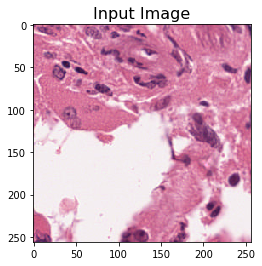

In [3]:
inputImageFile = ('/media/raj/Raj1_5/10ktiles/train/gbm/TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')  # H&E.png

imInput = skimage.io.imread(inputImageFile)[:, :, :3]

plt.imshow(imInput)
_ = plt.title('Input Image', fontsize=16)

### K Means Cluster Analysis

In [ ]:
# Converting 3D image data into 2D data for k-means clustering
x, y, z = imInput.shape
image_2d = imInput.reshape(x*y, z)
image_2d.shape

In [ ]:
# Applying K-means clusters on the given image
# As the input is image object, the clusters are color intensity
# Based on pixel (colored) distances from the respective cluster_centers
kmeans_cluster_00 = cluster.KMeans(n_clusters=3)
kmeans_cluster_00.fit(image_2d)
cluster_centers_00 = kmeans_cluster_00.cluster_centers_
cluster_labels_00 = kmeans_cluster_00.labels_

In [ ]:
cluster_labels_00

In [ ]:
cluster_centers_00

In [ ]:
kmeans_cluster_00.cluster_centers_[:,0]

In [ ]:
kmeans_cluster_00.cluster_centers_[:,1]

In [ ]:
kmeans_cluster_00.cluster_centers_[:,2]

In [ ]:
white = 0
purple = 0
pink = 0
for i in range (0,65535):
    if (cluster_labels_00[i] == 0): white=white+1
    if (cluster_labels_00[i] == 1): pink=pink+1
    if (cluster_labels_00[i] == 2): purple=purple+1

print (purple, white, pink)

In [ ]:
from matplotlib.ticker import FormatStrFormatter

data = cluster_labels_00
fig, ax = plt.subplots()
counts, bins, patches = ax.hist(data, facecolor='yellow', edgecolor='gray')
# Set the ticks to be at the edges of the bins.
ax.set_xticks(bins)
ax.set_title('k-means cluster centers of histo image')
ax.set_ylabel('# of image Pixels')
ax.set_xlabel('Bin:White Pixels                      Bin:Pink Pixels                Bin:Purple Pixels  ')

plt.show()

In [ ]:
plt.xlabel= "Red"
plt.ylabel= "Green"
plt.scatter(image_2d[:,0],image_2d[:,1],image_2d[:,2], c=kmeans_cluster_00.labels_, cmap='rainbow') 
plt.scatter(kmeans_cluster_00.cluster_centers_[:,0],kmeans_cluster_00.cluster_centers_[:,1],kmeans_cluster_00.cluster_centers_[:,2], color='black')

In [ ]:
# To run the silhouette analysis
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

for i, k in enumerate([2, 3, 4]):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # Run the Kmeans algorithm
    km = KMeans(n_clusters=k)
    labels = km.fit_predict(image_2d)
    centroids = km.cluster_centers_

    # Get silhouette samples
    silhouette_vals = silhouette_samples(image_2d, labels)

    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette plot for the various clusters', y=1.02);
    
    # Scatter plot of data colored with labels
    ax2.scatter(image_2d[:, 0], image_2d[:, 1], c=labels)
    #ax2.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='r', s=250)
    ax2.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], marker='*', c='r')
    ax2.set_xlim([-2, 2])
    ax2.set_xlim([-2, 2])
    ax2.set_xlabel('Eruption time in mins')
    ax2.set_ylabel('Waiting time to next eruption')
    ax2.set_title('Visualization of clustered data', y=1.02)
    ax2.set_aspect('equal')
    plt.tight_layout()
    plt.suptitle(f'Silhouette analysis using k = {k}',
                 fontsize=16, fontweight='semibold', y=1.05);

#### Purple, Pink White Pixels - Extraction

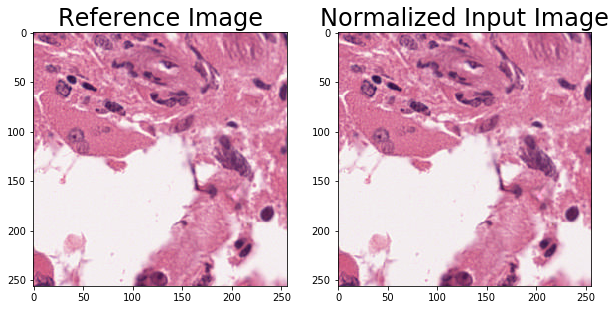

In [4]:
# Load reference image for normalization
ref_image_file = ('/media/raj/Raj1_5/10ktiles/train/gbm/TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')  # L1.png

im_reference = skimage.io.imread(ref_image_file)[:, :, :3]

# get mean and stddev of reference image in lab space
mean_ref, std_ref = htk.preprocessing.color_conversion.lab_mean_std(im_reference)

# perform reinhard color normalization
im_nmzd = htk.preprocessing.color_normalization.reinhard(imInput, mean_ref, std_ref)

# Display results
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(im_reference)
_ = plt.title('Reference Image', fontsize=titlesize)

plt.subplot(1, 2, 2)
plt.imshow(im_nmzd)
_ = plt.title('Normalized Input Image', fontsize=titlesize)

In [20]:
# create stain to color map using HistomicsTK
stain_color_map = htk.preprocessing.color_deconvolution.stain_color_map
print('stain_color_map:', stain_color_map, sep='\n')

# specify stains of input image
stains = ['hematoxylin',  # nuclei stain
          'eosin',        # cytoplasm stain
          'null']         # set to null if input contains only two stains

# create stain matrix
W = np.array([stain_color_map[st] for st in stains]).T
w_init=[]

# perform standard color deconvolution
#img_sda = htk.preprocessing.color_conversion.rgb_to_sda(im_nmzd,None)
#img_snmf_matrix = htk.preprocessing.color_deconvolution.color_deconvolution(img_sda, w_init)
imDeconvolved = htk.preprocessing.color_deconvolution.color_deconvolution(im_nmzd, W)
#

imDeconvolved = htk.preprocessing.color_deconvolution.color_deconvolution(img_snmf_matrix, W)


# Display results
for i in 0, 1:
    plt.figure()
    plt.imshow(imDeconvolved.Stains[:, :, i])
    _ = plt.title(stains[i], fontsize=titlesize)

stain_color_map:
{'hematoxylin': [0.65, 0.7, 0.29], 'eosin': [0.07, 0.99, 0.11], 'dab': [0.27, 0.57, 0.78], 'null': [0.0, 0.0, 0.0]}


TypeError: list indices must be integers or slices, not tuple

In [6]:
# Calculating Purple, Pink, White Pixels' - x,y co-ordinates
# Purple pixel:Cell Nuclie Material, 
# Pink Pixel:Stroma, Stomal cells’ cytoplasams, mucin-poor epithelial cells’s cytoplasms
# White pixels - Lumina, mucin-rich epithelial cells’s cytoplasms
def pixel_obj_gen(img_shape,imDecon_stains):  
    # Calculating hematoxylin average
    h_avg = np.average(imDecon_stains.Stains[:, :, 0])

    # Calculating Eosin average
    e_avg = np.average(imDecon_stains.Stains[:, :, 1])
    
    purple_pixel = []
    pink_pixel = []
    white_pixel = []
    purple_x = []
    purple_y = []
    pink_x = []
    pink_y = []
    white_x = []
    white_y = []
    for i in range(0,256):
          for j in range(0,256):
                h_p = imDecon_stains.Stains[i,j,0] 
                e_p = imDecon_stains.Stains[i,j,1]
                if h_p <= h_avg: purple_pixel.append([i,j,h_p,e_p]),purple_x.append([i]),purple_y.append([j])
                if (h_p > h_avg and e_p <= e_avg): pink_pixel.append([i,j,h_p,e_p]),pink_x.append([i]),pink_y.append([j])
                if (h_p > h_avg and e_p > e_avg): white_pixel.append([i,j,h_p,e_p]),white_x.append([i]),white_y.append([j])
    return purple_pixel, purple_x, purple_y, pink_pixel, pink_x, pink_y, white_pixel, white_x, white_y

In [7]:
img_shape = imInput.shape
imDecon_stains = imDeconvolved  

purple_pixel, purple_x, purple_y, pink_pixel, pink_x, pink_y, white_pixel, white_x, white_y = pixel_obj_gen(img_shape,imDecon_stains)

In [8]:
len(purple_pixel), len(white_pixel), len(pink_pixel)

(33068, 26494, 5974)

stain_color_map:
{'hematoxylin': [0.65, 0.7, 0.29], 'eosin': [0.07, 0.99, 0.11], 'dab': [0.27, 0.57, 0.78], 'null': [0.0, 0.0, 0.0]}


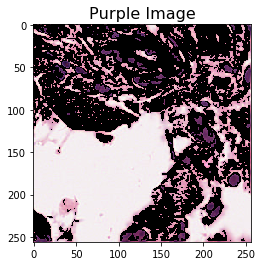

In [11]:
#### To display Purple images
inputImageFile = ('/media/raj/Raj1_5/10ktiles/train/gbm/TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')  # H&E.png
imOrig = skimage.io.imread(inputImageFile)[:, :, :3]

imPurple = imOrig.copy()

stain_color_map = htk.preprocessing.color_deconvolution.stain_color_map
print('stain_color_map:', stain_color_map, sep='\n')

# specify stains of input image
stains = ['hematoxylin',  # nuclei stain
          'eosin',        # cytoplasm stain
          'null']         # set to null if input contains only two stains

# create stain matrix
W = np.array([stain_color_map[st] for st in stains]).T

# perform standard color deconvolution
imDeconvolved_Purple = htk.preprocessing.color_deconvolution.color_deconvolution(im_nmzd, W)

# Calculating hematoxylin average
h_avg = np.average(imDeconvolved_Purple.Stains[:, :, 0])

for i in range(0,256):
    for j in range(0,256):
        if(imDeconvolved_Purple.Stains[i,j,0]>h_avg):imPurple[i,j,:]=0
            
plt.imshow(imPurple)
_ = plt.title('Purple Image', fontsize=16)

In [ ]:
plt.imshow(imOrig)
_ = plt.title('Original Image', fontsize=16)

stain_color_map:
{'hematoxylin': [0.65, 0.7, 0.29], 'eosin': [0.07, 0.99, 0.11], 'dab': [0.27, 0.57, 0.78], 'null': [0.0, 0.0, 0.0]}


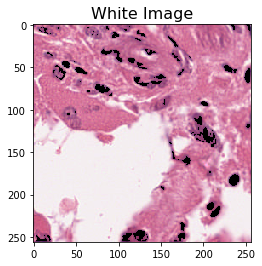

In [15]:
#### To display White images
inputImageFile = ('/media/raj/Raj1_5/10ktiles/train/gbm/TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')  # H&E.png
imOrig = skimage.io.imread(inputImageFile)[:, :, :3]

imWhite = imOrig.copy()

stain_color_map = htk.preprocessing.color_deconvolution.stain_color_map
print('stain_color_map:', stain_color_map, sep='\n')

# specify stains of input image
stains = ['hematoxylin',  # nuclei stain
          'eosin',        # cytoplasm stain
          'null']         # set to null if input contains only two stains

# create stain matrix
W = np.array([stain_color_map[st] for st in stains]).T

# perform standard color deconvolution
imDeconvolved_white = htk.preprocessing.color_deconvolution.color_deconvolution(im_nmzd, W)

# Calculating hematoxylin average
h_avg = np.average(imDeconvolved_white.Stains[:, :, 0])

# Calculating Eosin average
e_avg = np.average(imDeconvolved_white.Stains[:, :, 1])

for i in range(0,255):
    for j in range(0,255):
        if(imDeconvolved_white.Stains[i,j,0]<=h_avg and  imDeconvolved_white.Stains[i,j,1] <= e_avg): imWhite[i,j,:]=0                  


plt.imshow(imWhite)
_ = plt.title('White Image', fontsize=16)

stain_color_map:
{'hematoxylin': [0.65, 0.7, 0.29], 'eosin': [0.07, 0.99, 0.11], 'dab': [0.27, 0.57, 0.78], 'null': [0.0, 0.0, 0.0]}


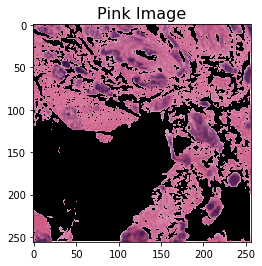

In [13]:
#### To display Pink images
inputImageFile = ('/media/raj/Raj1_5/10ktiles/train/gbm/TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')  # H&E.png
imOrig = skimage.io.imread(inputImageFile)[:, :, :3]
imPink = imOrig.copy()

stain_color_map = htk.preprocessing.color_deconvolution.stain_color_map
print('stain_color_map:', stain_color_map, sep='\n')

# specify stains of input image255 
stains = ['hematoxylin',  # nuclei stain
          'eosin',        # cytoplasm stain
          'null']         # set to null if input contains only two stains

# create stain matrix
W = np.array([stain_color_map[st] for st in stains]).T

# perform standard color deconvolution
imDeconvolved_Pink = htk.preprocessing.color_deconvolution.color_deconvolution(im_nmzd, W)

# Calculating hematoxylin average
h_avg = np.average(imDeconvolved_Pink.Stains[:, :, 0])

# Calculating Eosin average
e_avg = np.average(imDeconvolved_Pink.Stains[:, :, 1])

for i in range(0,255):
    for j in range(0,255):
        if(imDeconvolved_Pink.Stains[i,j,0]<=h_avg and imDeconvolved_Pink.Stains[i,j,1] > e_avg): imPink[i,j,:]=0        
        
plt.imshow(imPink)
_ = plt.title('Pink Image', fontsize=16)

In [ ]:
plt.imshow(imOrig)
_ = plt.title('Original Image', fontsize=16)

In [ ]:
#### Pixels count with their colors and H&E stain values
pink_x=[]
pink_y=[]
pink_h=[]
pink_e=[]
purple_x=[]
purple_y=[]
purple_h=[]
white_x=[]
white_y=[]
white_h=[]
white_e=[]

for i in range(0,256):
   for j in range(0,256):
       if(imDeconvolved_Purple.Stains[i,j,0]<=h_avg):purple_x.append(i),purple_y.append(j),purple_h.append(imDeconvolved_Purple.Stains[i,j,0])
       if(imDeconvolved_Pink.Stains[i,j,0]>h_avg and  imDeconvolved_Pink.Stains[i,j,1] <= e_avg):pink_x.append(i),pink_y.append(j),pink_h.append(imDeconvolved_Pink.Stains[i,j,0]),pink_e.append(imDeconvolved_Pink.Stains[i,j,1])
       if(imDeconvolved_white.Stains[i,j,0]>h_avg and  imDeconvolved_white.Stains[i,j,1] > e_avg):white_x.append(i),white_y.append(j),white_h.append(imDeconvolved_white.Stains[i,j,0]),white_e.append(imDeconvolved_white.Stains[i,j,1])
        
len(pink_x), len(pink_y), len(white_x), len(white_y), len(purple_x), len(purple_y)

#### Histologic Circular Objects identification 

#### Purple, Pink White Pixels - Extraction through Color Normalization, Image De-convolution

In [ ]:
inputImageFile = ('/media/raj/Raj1_5/10ktiles/train/gbm/TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png') 
imInput = skimage.io.imread(inputImageFile)[:, :, :3]

# get mean and stddev of reference image in lab space
mean_ref, std_ref = htk.preprocessing.color_conversion.lab_mean_std(imInput)

# perform reinhard color normalization
im_nmzd = htk.preprocessing.color_normalization.reinhard(imInput, mean_ref, std_ref)

# Display results
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(imInput)
_ = plt.title('Reference Image', fontsize=titlesize)

plt.subplot(1, 2, 2)
plt.imshow(im_nmzd)
_ = plt.title('Normalized Input Image', fontsize=titlesize)

In [ ]:
# create stain to color map
stainColorMap = {
    'hematoxylin': [0.65, 0.70, 0.29],
    'eosin':       [0.07, 0.99, 0.11],
    'dab':         [0.27, 0.57, 0.78],
    'null':        [0.0, 0.0, 0.0]
}

# specify stains of input image
stain_1 = 'hematoxylin'   # nuclei stain
stain_2 = 'eosin'         # cytoplasm stain
stain_3 = 'null'          # set to null of input contains only two stains

# create stain matrix
W = np.array([stainColorMap[stain_1],
              stainColorMap[stain_2],
              stainColorMap[stain_3]]).T

# perform standard color deconvolution
im_stains = htk.preprocessing.color_deconvolution.color_deconvolution(im_nmzd, W).Stains

# Display results
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(im_stains[:, :, 0])
plt.title(stain_1, fontsize=titlesize)

plt.subplot(1, 2, 2)
plt.imshow(im_stains[:, :, 1])
_ = plt.title(stain_2, fontsize=titlesize)

In [ ]:
# Calculating Purple, Pink, White Pixels' - x,y co-ordinates
# Purple pixel:Cell Nuclie Material, 
# Pink Pixel:Stroma, Stomal cells’ cytoplasams, mucin-poor epithelial cells’s cytoplasms
# White pixels - Lumina, mucin-rich epithelial cells’s cytoplasms
def pixel_obj_gen1(img_shape,imDecon_stains):  
    # Calculating hematoxylin average
    h_avg = np.average(im_stains[:, :, 0])

    # Calculating Eosin average
    e_avg = np.average(im_stains[:, :, 1])
    
    purple_pixel = []
    pink_pixel = []
    white_pixel = []
    purple_x = []
    purple_y = []
    pink_x = []
    pink_y = []
    white_x = []
    white_y = []
    for i in range(0,img_shape[0]):
          for j in range(0,img_shape[1]):
                h_p = imDecon_stains[i,j,0] 
                e_p = imDecon_stains[i,j,1]
                if h_p <= h_avg: purple_pixel.append([i,j,h_p,e_p]),purple_x.append([i]),purple_y.append([j])
                if (h_p > h_avg and e_p <= e_avg): pink_pixel.append([i,j,h_p,e_p]),pink_x.append([i]),pink_y.append([j])
                if (h_p > h_avg and e_p > e_avg): white_pixel.append([i,j,h_p,e_p]),white_x.append([i]),white_y.append([j])
    return purple_pixel, purple_x, purple_y, pink_pixel, pink_x, pink_y, white_pixel, white_x, white_y

In [ ]:
img_shape = imInput.shape
imDecon_stains = im_stains
purple_pixel, purple_x, purple_y, pink_pixel, pink_x, pink_y, white_pixel, white_x, white_y = pixel_obj_gen1(img_shape,imDecon_stains)

In [ ]:
len(purple_pixel), len(white_pixel), len(pink_pixel)

#### Segment Nuclei

In [ ]:
# get nuclei/hematoxylin channel
im_nuclei_stain = im_stains[:, :, 0]

# segment foreground
foreground_threshold = 60

im_fgnd_mask = sp.ndimage.morphology.binary_fill_holes(
    im_nuclei_stain < foreground_threshold)

# run adaptive multi-scale LoG filter
min_radius = 10
max_radius = 15

im_log_max, im_sigma_max = htk.filters.shape.cdog(
    im_nuclei_stain, im_fgnd_mask,
    sigma_min=min_radius * np.sqrt(2),
    sigma_max=max_radius * np.sqrt(2)
)

# detect and segment nuclei using local maximum clustering
local_max_search_radius = 10

im_nuclei_seg_mask, seeds, maxima = htk.segmentation.nuclear.max_clustering(
    im_log_max, im_fgnd_mask, local_max_search_radius)

# filter out small objects
min_nucleus_area = 80

im_nuclei_seg_mask = htk.segmentation.label.area_open(
    im_nuclei_seg_mask, min_nucleus_area).astype(np.int)

# compute nuclei properties
objProps = skimage.measure.regionprops(im_nuclei_seg_mask)

print ('Number of nuclei = ', len(objProps))

# Display results
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(skimage.color.label2rgb(im_nuclei_seg_mask, imInput, bg_label=0), origin='lower')
plt.title('Nuclei segmentation mask overlay', fontsize=titlesize)

plt.subplot(1, 2, 2)
plt.imshow( imInput )
plt.xlim([0, imInput.shape[1]])
plt.ylim([0, imInput.shape[0]])
plt.title('Nuclei bounding boxes', fontsize=titlesize)

for i in range(len(objProps)):

    c = [objProps[i].centroid[1], objProps[i].centroid[0], 0]
    width = objProps[i].bbox[3] - objProps[i].bbox[1] + 1
    height = objProps[i].bbox[2] - objProps[i].bbox[0] + 1

    cur_bbox = {
        "type":        "rectangle",
        "center":      c,
        "width":       width,
        "height":      height,
    }

    plt.plot(c[0], c[1], 'g+')
    mrect = mpatches.Rectangle([c[0] - 0.5 * width, c[1] - 0.5 * height] ,
                               width, height, fill=False, ec='g', linewidth=2)
    plt.gca().add_patch(mrect)

### PCA Analysis for the intended image

In [ ]:
from sklearn.decomposition import PCA
import pandas as pd

In [ ]:
pca = PCA(n_components=1)
pca.fit(image_2d)
X_pca = pca.transform(image_2d)
print("original shape:   ",image_2d.shape)
print("transformed shape:", X_pca.shape)

In [ ]:
c1=np.asarray(cluster_labels_00)
c2=c1.reshape(65536,1)
c2.shape

In [ ]:
result = np.concatenate((image_2d,X_pca),axis=1)
result1= np.concatenate((X_pca,c2),axis=1)
print(result1)

In [ ]:
np.savetxt('/home/raj/Downloads/image_2d_Xpca.csv', result1,delimiter=',')

In [ ]:
result1.shape

In [ ]:
result2=result1.reshape(256,256,2)

In [ ]:
result2[0,0,1]

In [ ]:
cluster_centers_00

In [ ]:
### create 3 clusters (Purple, White, Pink) with their x,y coordinates and PCA values of each point
clust_W_x=[]
clust_W_y=[]
clust_W_pca=[]
clust_Pu_x=[]
clust_Pu_y=[]
clust_Pu_pca=[]
clust_Pk_x=[]
clust_Pk_y=[]
clust_Pk_pca=[]
for i in range(0,256):
    for j in range(0,256):
        if(result2[i,j,1]==0):clust_W_x.append(i), clust_W_y.append(j),clust_W_pca.append(result2[i,j,0])
        if(result2[i,j,1]==1):clust_Pk_x.append(i), clust_Pk_y.append(j),clust_Pk_pca.append(result2[i,j,0])
        if(result2[i,j,1]==2):clust_Pu_x.append(i), clust_Pu_y.append(j),clust_Pu_pca.append(result2[i,j,0])  

In [ ]:
clust_W_xy_pca=np.vstack((clust_W_x, clust_W_y,clust_W_pca)).T
clust_Pu_xy_pca=np.vstack((clust_Pu_x, clust_Pu_y,clust_Pu_pca)).T
clust_Pk_xy_pca=np.vstack((clust_Pk_x, clust_Pk_y,clust_Pk_pca)).T

In [ ]:
clust_W_xy_pca.shape, clust_Pu_xy_pca.shape, clust_Pk_xy_pca.shape

In [ ]:
X_new = pca.inverse_transform(X_pca)
plt.scatter(image_2d[:, 0], image_2d[:, 1], alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.axis('equal')

In [ ]:
np.savetxt('/home/raj/Downloads/clust_W_xy_pca.csv', clust_W_xy_pca,delimiter=',')
np.savetxt('/home/raj/Downloads/clust_Pu_xy_pca.csv', clust_Pu_xy_pca,delimiter=',')
np.savetxt('/home/raj/Downloads/clust_Pk_xy_pca.csv', clust_Pk_xy_pca,delimiter=',')

In [ ]:
min(clust_W_pca), max(clust_W_pca), max(clust_W_pca) - min (clust_W_pca)

In [ ]:
min(clust_Pu_pca), max(clust_Pu_pca), max(clust_Pu_pca) - min (clust_Pu_pca),

In [ ]:
min(clust_Pk_pca), max(clust_Pk_pca), max(clust_Pk_pca) - min (clust_Pk_pca)

In [ ]:
### Sort by PCA values in the cluster_W, cluster_Pu, cluster_Pk
from operator import itemgetter
sorted_clust_W = sorted(clust_W_xy_pca, key=itemgetter(2))
sorted_clust_Pu = sorted(clust_Pu_xy_pca, key=itemgetter(2))
sorted_clust_Pk = sorted(clust_Pk_xy_pca, key=itemgetter(2))

In [ ]:
sorted_clust_Pk

#### Draw Circles on different components (White, Purple, Pink)

In [ ]:
#### Draw circles, for each point in white, Purple, pink clusters with
#### Their x, y coordinates and range (Factor of max - min PCA)

In [ ]:
def first_factor(n):
    for num in range(2,n):
        if n % num == 0:
            return num

In [ ]:
def pt_ranges(clust_W_pca_max, clust_W_pca_min, clust_W_x):
    clust_W_pca_max = clust_W_pca_max
    clust_W_pca_min = clust_W_pca_min
    clust_W_x = clust_W_x
    pt_ranges = []
    
    factor = first_factor(int(clust_W_pca_max) - int(clust_W_pca_min))
    pt_ranges.append(clust_W_pca_min)        
        
    for i in np.arange(clust_W_pca_min, clust_W_pca_max-1, factor):        
        pt_range = i + factor
        pt_ranges.append(pt_range)
        #clust_W_pca_min = pt_range
        
    return pt_ranges

In [ ]:
factor = first_factor(int(max(clust_W_pca) - min(clust_W_pca)))
factor

In [ ]:
clust_W_pca_max = max(clust_W_pca)
clust_W_pca_min = min(clust_W_pca)
pt_ranges_w = pt_ranges(clust_W_pca_max, clust_W_pca_min, clust_W_x)

In [ ]:
#### To find the circle-fit coordinates with only one pt_range
def circle_fit_pts(clust_W_x, clust_W_y, clust_W_pca, pt_range):    
    circle_fit_pts_x = []
    circle_fit_pts_y = []
    pt_range = pt_range        
    
    for i in range(0, len(clust_W_x)):
        if clust_W_pca[i] <= pt_range: circle_fit_pts_x.append(clust_W_x[i]), circle_fit_pts_y.append(clust_W_y[i])
            
    x_center, y_center, radius = circle_fit(circle_fit_pts_x, circle_fit_pts_y, len(circle_fit_pts_x))
    return x_center, y_center, radius

# Drawing Circles for white cluster

In [ ]:
x_center_W = []
y_center_W = []
radius_W = []

for pt_range in pt_ranges_w:
    x_center_w, y_center_w, radius_w = circle_fit_pts(clust_W_x, clust_W_y, clust_W_pca, pt_range)
    x_center_W.append(x_center_w), y_center_W.append(y_center_w), radius_W.append(radius_w)
    #print (x_center, y_center, radius)
    
center_W =np.vstack((x_center_W, y_center_W, radius_W)).T
np.savetxt('/home/raj/Downloads/center_w.csv', center_W, delimiter=',')

In [ ]:
# Drawing Circles for white cluster
inputImageFile = ('/media/raj/Raj1_5/10ktiles/train/gbm/TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')  # H&E.png
imOrig = skimage.io.imread(inputImageFile)[:, :, :3]

imInput = imOrig.copy()

for pt_range in pt_ranges_w:
    x_center_w, y_center_w, radius_w = circle_fit_pts(clust_W_x, clust_W_y, clust_W_pca, pt_range)
    if ((not math.isnan(x_center_w)) or (not math.isnan(y_center_w)) or (not math.isnan(radius_w))):
        cv2.circle(imInput,(int(x_center_w),int(y_center_w)),int(radius_w),3)
        cv2.imwrite('/home/raj/Downloads/white_clustered_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png',
            cv2.cvtColor(imInput, cv2.COLOR_RGB2BGR))
           
im = cv2.imread('/home/raj/Downloads/white_clustered_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()

# Drawing Circles for Purple cluster

In [ ]:
factor = first_factor(int(max(clust_Pu_pca) - min(clust_Pu_pca)))
factor

clust_Pu_pca_max = max(clust_Pu_pca)
clust_Pu_pca_min = min(clust_Pu_pca)

pt_ranges_pu = pt_ranges(clust_Pu_pca_max, clust_Pu_pca_min, clust_Pu_x)

In [ ]:
x_center_Pu = []
y_center_Pu = []
radius_Pu = []

for pt_range in pt_ranges_pu:
    x_center_pu, y_center_pu, radius_pu = circle_fit_pts(clust_Pu_x, clust_Pu_y, clust_Pu_pca, pt_range)
    x_center_Pu.append(x_center_pu), y_center_Pu.append(y_center_pu), radius_Pu.append(radius_pu)    
    
center_pu =np.vstack((x_center_pu, y_center_pu, radius_pu)).T
np.savetxt('/home/raj/Downloads/center_pu.csv', center_pu, delimiter=',')

In [ ]:
# Drawing Circles for purple cluster
inputImageFile = ('/media/raj/Raj1_5/10ktiles/train/gbm/TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')  # H&E.png
imOrig = skimage.io.imread(inputImageFile)[:, :, :3]

imInput = imOrig.copy()

for pt_range_pu in pt_ranges_pu:
    x_center_pu, y_center_pu, radius_pu = circle_fit_pts(clust_Pu_x, clust_Pu_y, clust_Pu_pca, pt_range_pu)
    if ((not math.isnan(x_center_pu)) or (not math.isnan(y_center_pu)) or (not math.isnan(radius_pu))):
        cv2.circle(imInput,(int(x_center_pu),int(y_center_pu)),int(radius_pu),3)
        cv2.imwrite('/home/raj/Downloads/purple_clustered_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png',
            cv2.cvtColor(imInput, cv2.COLOR_RGB2BGR))
           
im = cv2.imread('/home/raj/Downloads/purple_clustered_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()

### Drawing Circles for Pink cluster

In [ ]:
factor = first_factor(int(max(clust_Pk_pca) - min(clust_Pk_pca)))
factor

clust_Pk_pca_max = max(clust_Pk_pca)
clust_Pk_pca_min = min(clust_Pk_pca)
pt_ranges_pk = pt_ranges(clust_Pk_pca_max, clust_Pk_pca_min, clust_Pk_x)

In [ ]:
x_center_Pk = []
y_center_Pk = []
radius_Pk = []

for pt_range in pt_ranges_pk:
    x_center_pk, y_center_pk, radius_pk = circle_fit_pts(clust_Pk_x, clust_Pk_y, clust_Pk_pca, pt_range)
    x_center_Pk.append(x_center_pk), y_center_Pk.append(y_center_pk), radius_Pk.append(radius_pk)    
    
center_pk =np.vstack((x_center_pk, y_center_pk, radius_pk)).T
np.savetxt('/home/raj/Downloads/center_pk.csv', center_pk, delimiter=',')

In [ ]:
# Drawing Circles for pink cluster
inputImageFile = ('/media/raj/Raj1_5/10ktiles/train/gbm/TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')  # H&E.png
imOrig = skimage.io.imread(inputImageFile)[:, :, :3]

imInput = imOrig.copy()

for pt_range_pk in pt_ranges_pk:
    x_center_pk, y_center_pk, radius_pk = circle_fit_pts(clust_Pk_x, clust_Pk_y, clust_Pk_pca, pt_range_pk)
    if ((not math.isnan(x_center_pk)) or (not math.isnan(y_center_pk)) or (not math.isnan(radius_pk))):
        cv2.circle(imInput,(int(x_center_pk),int(y_center_pk)),int(radius_pk),3)
        cv2.imwrite('/home/raj/Downloads/pink_clustered_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png',
            cv2.cvtColor(imInput, cv2.COLOR_RGB2BGR))
           
im = cv2.imread('/home/raj/Downloads/pink_clustered_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
clust_W_pca_min = min(clust_W_pca)
clust_W_pca_max = max(clust_W_pca) 

pt_ranges = pt_ranges(clust_W_pca_max, clust_W_pca_min, clust_W_x)

In [ ]:
x_centers, y_centers, radius_s = circle_fit_pts(clust_W_x, clust_W_y, clust_W_pca, pt_ranges)

In [ ]:
#### Drawing circles for white_cluster
x_center, y_center, radius = circle_fit_pts(clust_W_x, clust_W_y, pt_ranges)

In [ ]:
xc1,yc1,r1

In [ ]:
#### To find the circle-fit coordinates  
def circle_fit_pts(clust_W_x, clust_W_y, clust_W_pca, pt_ranges):    
    circle_fit_pts_x = []
    circle_fit_pts_y = []
    pt_ranges = pt_ranges
    x_centers = []
    y_centers = []
    radius_s = []
    clust_W_pca = clust_W_pca
    
    for pt_range in pt_ranges:        
        for i in range (0, len(clust_W_x)):
            if clust_W_pca[i] <= pt_range: circle_fit_pts_x.append(clust_W_x[i]), circle_fit_pts_y.append(clust_W_y[i])
            
        x_center, y_center, radius = circle_fit(circle_fit_pts_x, circle_fit_pts_y, len(circle_fit_pts_x))
        x_centers.append(x_center), y_centers.append(y_center), radius_s.append(radius)        
    
    return x_centers, y_centers, radius_s

In [ ]:
# !pip install circle-fit
import circle_fit as cf

In [ ]:
### circle_fit(x_coords,y_coords,pixel_len)
### xc_00_0_0,yc_00_0_0,r_00_0_0,_ = cf.least_squares_circle((cluster_00_0_0xy))

In [ ]:
# Combining x,y coordinates for White Cluster, Purple Cluster, Pink Cluster
clust_W_xy = np.vstack((clust_W_x, clust_W_y)).T
clust_Pu_xy = np.vstack((clust_Pu_x, clust_Pu_y)).T
clust_Pk_xy = np.vstack((clust_Pk_x, clust_Pk_y)).T

In [ ]:
clust_W_xy.shape, clust_Pu_xy.shape, clust_Pk_xy.shape

In [ ]:
W_xc,W_yc,W_r,_ = cf.least_squares_circle((clust_W_xy))

In [ ]:
W_xc,W_yc,W_r

In [ ]:
# Drawing Circles for white cluster
inputImageFile = ('/media/raj/Raj1_5/10ktiles/train/gbm/TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')  # H&E.png
imOrig = skimage.io.imread(inputImageFile)[:, :, :3]

imInput = imOrig.copy()
cv2.circle(imInput,(int(W_xc),int(W_yc)),int(W_r),3)

cv2.imwrite('/home/raj/Downloads/white_clustered_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png',
            cv2.cvtColor(imInput, cv2.COLOR_RGB2BGR))
           
im = cv2.imread('/home/raj/Downloads/white_clustered_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')

plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# To save the image data into csv file to do PCA
cluster_labels4d=tuple(zip(*zip(*image_2d),cluster_labels_00))
np.savetxt('/home/raj/Downloads/kmeans_data.csv', cluster_labels4d, delimiter=',')
np.savetxt('/home/raj/Downloads/df1.csv', image_2d, delimiter=',')
np.savetxt('/home/raj/Downloads/df1_cluster_labels.csv', cluster_labels_00, delimiter=',')

In [ ]:
# To generate white (Cluster0), purple (cluster1), pink (cluster2) object coordinates - 2D
cluster_labels1=np.zeros((256,256))
cluster_labels1= cluster_labels_00.reshape(256, 256)
white=[]
purple=[]
pink=[]

for i in range(0,255):
    for j in range(0,255):        
        if (cluster_labels1[i,j] == 0): white.append([i,j])
        if (cluster_labels1[i,j] == 1): purple.append([i,j])
        if (cluster_labels1[i,j] == 2): pink.append([i,j])

In [ ]:
cluster_labels_00[0], cluster_labels_00[1], cluster_labels_00[2]

In [ ]:
# To generate white (Cluster0), purple (cluster1), pink (cluster2) object positions
w = []
pur = []
pink = []

for i in range(0,65535):
    if (cluster_labels_00[i] == 0): w.append(i)
    if (cluster_labels_00[i] == 1): pur.append(i)
    if (cluster_labels_00[i] == 2): pink.append(i)    

In [ ]:
white[500],  w[500],white[1500],  w[1500], white[300],  w[300]

In [ ]:
# To identify/order all points which have least distance among themselves in a cluster
import math
pt_dist_coords = []
ld_pt = 0.0
ld_pt_coords = [0,0]

for i in range(0,255):
    for j in range(0,255):
        x_coords_sq = (white[i+1][0] - white[i][0])**2
        y_coords_sq = (white[j+1][1] - white[j][1])**2
        pt_dist = math.sqrt(x_coords_sq+y_coords_sq)
        
        if pt_dist < ld_pt:
            ld_pt_coords = [i,j]
            ld_pt = pt_dist            
        else: 
            pt_dist_coords.append([i,j])
        
#sorted_list = sorted(pt_dist_coords, key=lambda x: x[2])

In [ ]:
sorted_list

In [ ]:
ld_pt

#### Image Pixels color predicition from Kmeans cluster_centers

In [ ]:
cluster_points =kmeans_cluster_00.predict(image_2d)

In [ ]:
cluster_2 = np.where(cluster_points == 2)
cluster_2

In [ ]:
cluster_1 = np.where(cluster_points == 1)
cluster_1

In [ ]:
cluster_0 = np.where(cluster_points == 0)
cluster_0

In [ ]:
cluster_1[0][0], image_2d[37,:]

In [ ]:
cluster_labels_00[0]

In [ ]:
image_2d[0,:],image_2d[1,:],image_2d[11,:], image_2d[37,:], image_2d[38,:],image_2d[39,:],image_2d[2,:], image_2d[3,:], image_2d[4,:]

In [ ]:
cluster_labels_00

In [ ]:
cluster_labels_00

In [ ]:
# Each row represents respective cluster# 
# Each column in each row represents color intensity (RGB)
# For Eg, in this case, 3 clusters with their RGB values
# Cluster#0 is clustered with (243.01990705, 229.31279562, 233.74852959)
cluster_centers_00

In [ ]:
from matplotlib.ticker import FormatStrFormatter

data = cluster_labels_00
fig, ax = plt.subplots()
counts, bins, patches = ax.hist(data, facecolor='yellow', edgecolor='gray')
ax.set_title('k-means cluster centers of histo image')
ax.set_ylabel('# of image Pixels')
ax.set_xlabel('White-Like                         Purple-Like               Pink-Like Pixels')

plt.show()

In [ ]:
white = 0
purple = 0
pink = 0
for i in range (0,65535):
    if (cluster_labels_00[i] == 0): white=white+1
    if (cluster_labels_00[i] == 1): purple=purple+1
    if (cluster_labels_00[i] == 2): pink=pink+1

print (white, purple, pink)

In [ ]:
plt.scatter(image_2d[:,0],image_2d[:,1],image_2d[:,2], c=kmeans_cluster_00.labels_, cmap='rainbow') 
plt.scatter(kmeans_cluster_00.cluster_centers_[:,0],kmeans_cluster_00.cluster_centers_[:,1],kmeans_cluster_00.cluster_centers_[:,2], color='black')  

In [ ]:
# To get the IDs of the points/samples that are inside each cluster
def ClusterIndicesNumpy(clustNum, labels_array): #numpy 
    return np.where(labels_array == clustNum)[0]

In [ ]:
ClusterIndicesNumpy(0, cluster_labels_00), ClusterIndicesNumpy(1, cluster_labels_00), ClusterIndicesNumpy(2, cluster_labels_00)

In [ ]:
#To calculate the linear distance between cluster points
white_pixel_datapoints = ClusterIndicesNumpy(0, cluster_labels_00)

In [ ]:
def pointsCoordinates(currentdata, datasize):
    datalength = datasize - 1 # Python array starts at 0
    ptcoord = []
    for eachpt in (currentdata):
        if eachpt < 255 : ptcoord.append (0, eachpt)

In [ ]:
wh_2d = np.reshape(white_pixel_datapoints, (-1,2))

In [ ]:
wh_2d

In [ ]:
#### PCA Tissue type distribution 
from sklearn.preprocessing import StandardScaler
cluster_labels4d=tuple(zip(*zip(*image_2d),cluster_labels_00))
np.savetxt('/home/raj/Downloads/kmeans_data.csv', cluster_labels4d, delimiter=',')
df = pd.read_csv('/home/raj/Downloads/kmeans_data.csv',names=['Red','Green','Blue','Cluster_No'])

features = ['Red','Green','Blue']
# Separating out the features
x = df.loc[:, features].values
# Separating out the target
y = df.loc[:,['Cluster_No']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PCA1'])
finalDf = pd.concat([principalDf, df[['Cluster_No']]], axis = 1)

# PCA to get the circular objects

In [ ]:
from sklearn.decomposition import PCA
import pandas as pd

In [ ]:
# To save the image data into csv file to do PCA
cluster_labels4d=tuple(zip(*zip(*image_2d),cluster_labels_00))
np.savetxt('/home/raj/Downloads/kmeans_data.csv', cluster_labels4d, delimiter=',')
np.savetxt('/home/raj/Downloads/df1.csv', image_2d, delimiter=',')
np.savetxt('/home/raj/Downloads/df1_cluster_labels.csv', cluster_labels_00, delimiter=',')

In [ ]:
df = pd.read_csv('/home/raj/Downloads/kmeans_data.csv',names=['Red','Green','Blue','Cluster_No'])

In [ ]:
from sklearn.preprocessing import StandardScaler
features = ['Red','Green','Blue']
# Separating out the features
x = df.loc[:, features].values
# Separating out the target
y = df.loc[:,['Cluster_No']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

In [ ]:
x

In [ ]:
y

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PCA1', 'PCA2'])

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
finalDf = pd.concat([principalDf, df[['Cluster_No']]], axis = 1)

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Tissue objects distribution-PCA', fontsize = 20)
targets = [0,1,2]
colors = ['w', 'purple', 'pink']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Cluster_No'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PCA1']
               , finalDf.loc[indicesToKeep, 'PCA2']
               , c = color)    
ax.legend(targets)
ax.grid()

# PCA for individual tissue components 

In [ ]:
cluster_labels_white = []
cluster_labels_purple = []
cluster_labels_pink = []

for i in range (0,65535):
    if (cluster_labels_00[i] == 0): cluster_labels_white.append(cluster_labels_00[i])
    if (cluster_labels_00[i] == 1): cluster_labels_purple.append(cluster_labels_00[i]) 
    if (cluster_labels_00[i] == 2): cluster_labels_pink.append(cluster_labels_00[i]) 

print (len(cluster_labels_white), len(cluster_labels_purple), len(cluster_labels_pink))

In [ ]:
cluster_labels4d=tuple(zip(*zip(*image_2d),cluster_labels_purple))
np.savetxt('/home/raj/Downloads/purple_data.csv', cluster_labels4d, delimiter=',')

In [ ]:
cluster_labels4d=tuple(zip(*zip(*image_2d),cluster_labels_white))
np.savetxt('/home/raj/Downloads/white_data.csv', cluster_labels4d, delimiter=',')

In [ ]:
cluster_labels4d=tuple(zip(*zip(*image_2d),cluster_labels_pink))
np.savetxt('/home/raj/Downloads/pink_data.csv', cluster_labels4d, delimiter=',')

# PCA on Cluster0 (White objects cluster)

In [ ]:
whitedf = pd.read_csv('/home/raj/Downloads/white_data.csv',names=['Red','Green','Blue','Cluster_No'])

In [ ]:
from sklearn.preprocessing import StandardScaler
features = ['Red','Green','Blue']
# Separating out the features
x = whitedf.loc[:, features].values
# Separating out the target
y = whitedf.loc[:,['Cluster_No']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

In [ ]:
x, y

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PCA1', 'PCA2'])

In [ ]:
finalDf = pd.concat([principalDf, df[['Cluster_No']]], axis = 1)

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Colored Tissue objects distribution-PCA', fontsize = 20)
targets = [0,1,2]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Cluster_No'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PCA1']
               , finalDf.loc[indicesToKeep, 'PCA2']
               , c = color)
ax.legend(targets)
ax.grid()

In [ ]:
imInput.shape, image_2d.shape

# PCA Analysis followed by K-means

In [ ]:
img_x = StandardScaler().fit_transform(image_2d)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
principalComponents = pca.fit_transform(img_x)
img_principalDf = pd.DataFrame(data = principalComponents, columns = ['PCA1'])

In [ ]:
principalComponents[37]

# To do - 07/12/19
# Create an array[cluster_img_white, principal 
# components[cluster_img_white]]
# Find mean of principal components[cluster_img_white], low, high values
# Draw circles iteratively using circle_fit

In [ ]:
kmeans_cluster_img = cluster.KMeans(n_clusters=3)
kmeans_cluster_img.fit(principalComponents)
cluster_centers_img = kmeans_cluster_img.cluster_centers_
cluster_labels_img = kmeans_cluster_img.labels_

In [ ]:
cluster_labels4d=tuple(zip(*zip(*principalComponents),cluster_labels_img))
np.savetxt('/home/raj/Downloads/kmeans_img.csv', cluster_labels4d, delimiter=',')

# Splitting up Tissue objects

In [ ]:
cluster_img_white = []
cluster_img_purple = []
cluster_img_pink = []

for i in range (0,65535):
    if (cluster_labels_img[i] == 0): cluster_img_white.append(i)
    if (cluster_labels_img[i] == 1): cluster_img_purple.append(i) 
    if (cluster_labels_img[i] == 2): cluster_img_pink.append(i) 

print (len(cluster_img_white), len(cluster_img_purple), len(cluster_img_pink))

In [ ]:
cluster_labels4d=tuple(zip(*zip(*principalComponents),cluster_img_white))
np.savetxt('/home/raj/Downloads/white_img.csv', cluster_labels4d, delimiter=',')
cluster_labels4d=tuple(zip(*zip(*principalComponents),cluster_img_purple))
np.savetxt('/home/raj/Downloads/purple_img.csv', cluster_labels4d, delimiter=',')
cluster_labels4d=tuple(zip(*zip(*image_2d),cluster_img_pink))
np.savetxt('/home/raj/Downloads/pink_img.csv', cluster_labels4d, delimiter=',')

In [ ]:
cluster_img_white

In [ ]:
white_reshaped[0]

In [ ]:
image_2d[1,:],image_2d[2,:]

In [ ]:
image_2d.shape, imInput.shape

In [ ]:
img_reshaped = np.reshape(image_2d, (256,256,3))

In [ ]:
import sklearn.datasets, sklearn.decomposition

mu = np.mean(img_x, axis=0)

pca = sklearn.decomposition.PCA()
pca.fit(img_x)

nComp = 1
Xhat = np.dot(pca.transform(img_x)[:,:nComp], pca.components_[:nComp,:])
Xhat += mu

print(Xhat[0,])

In [ ]:
Xhat.shape

In [ ]:
cluster_labels1=np.zeros((256,256))

In [ ]:
cluster_labels1= cluster_labels_00.reshape(256, 256)

In [ ]:
cluster_labels1.shape

In [ ]:
imOutput=cluster_centers_00[cluster_labels_00].reshape(x, y, z)

In [ ]:
plt.figure(figsize = (15,8))
plt.imshow((imOutput * 255).astype(np.uint8))

In [ ]:
imOutput.shape, imInput.shape

In [ ]:
imOutput.size

In [ ]:
cluster_labels_00

In [ ]:
import circle_fit as cf

# Finding Largest Circle Object of Tissue component  (LOT)  - Procedure

# Finding LOT for first cluster (Cluster0 of 1st run of k-means)

In [ ]:
# Adding up three cluster_positions with their x,y coordinates
cluster_00_x=[]
cluster_00_y=[]
cluster_01_x=[]
cluster_01_y=[]
cluster_02_x=[]
cluster_02_y=[]
for i in range(0,255):
       for j in range(0,255):
        if (cluster_labels1[i,j] == 0): cluster_00_x.append([i]),cluster_00_y.append([j])
        if (cluster_labels1[i,j] == 1): cluster_01_x.append([i]),cluster_01_y.append([j])
        if (cluster_labels1[i,j] == 2): cluster_02_x.append([i]),cluster_02_y.append([j])
z=len(cluster_00_x)+len(cluster_01_x)+len(cluster_02_x)
z

In [ ]:
# Identifying image positions/pixels matching nearest cluster0 intenstity values 
cluster_00_points = np.where(imInput ==(243, 229, 234)) #[243.01990705, 229.31279562, 233.74852959] Cluster#0 values

In [ ]:
len(cluster_00_points)

In [ ]:
cluster_00_points

In [ ]:
# Splitting up image positios/pixels of cluster_00_points into another 3 clusters
# k-means clustering on points distance from cluster_center
# As the input is pixel co-ordinates, clusters are based pixel distance from cluster_center
cluster_00_0x=[]
cluster_00_1x=[]
cluster_00_2x=[]
cluster_00_0y=[]
cluster_00_1y=[]
cluster_00_2y=[]
for i in range(0,3509):
        if (cluster_00_points[2][i] == 0): cluster_00_0x.append(cluster_00_points[0][i]), cluster_00_0y.append(cluster_00_points[1][i])
        if (cluster_00_points[2][i] == 1): cluster_00_1x.append(cluster_00_points[0][i]), cluster_00_1y.append(cluster_00_points[1][i])
        if (cluster_00_points[2][i] == 2): cluster_00_2x.append(cluster_00_points[0][i]), cluster_00_2y.append(cluster_00_points[1][i])  

In [ ]:
# Combining x,y coordinates for first cluster of cluster00
cluster_00_0_xy = np.vstack((cluster_00_0x, cluster_00_0y)).T 

In [ ]:
np.shape(cluster_00_0_xy)

In [ ]:
xc_00_0,yc_00_0,r_00_0,_ = cf.least_squares_circle((cluster_00_0_xy)) 

In [ ]:
len(cluster_00_0_xy),len(cluster_00_1x), len(cluster_00_2x) 

In [ ]:
cluster_00_0_xy[:,0]

In [ ]:
cluster_00_0_xy[:,1]

In [ ]:
kmeans_cluster_00_1 = cluster.KMeans(n_clusters=3)
kmeans_cluster_00_1.fit(cluster_00_0_xy)
cluster_00_1_centers= kmeans_cluster_00_1.cluster_centers_
cluster_00_1_labels= kmeans_cluster_00_1.labels_

In [ ]:
cluster_00_1_centers

In [ ]:
cluster_00_0_xy

In [ ]:
# Identifying image positions/pixels matching nearest cluster0 intenstity values 
cluster_00_1_points = np.where(cluster_00_0_xy ==[185,51]) #[185.4970684, 51.08338762] Cluster#00 values

In [ ]:
cluster_00_1_points

In [ ]:
np.shape(cluster_00_1_points)

In [ ]:
# Splitting up cluster_00_0_points into another 3 clusters 
# First cluster from cluster0(Image)->cluster0(coordinates)
# k-means clustering on points distance from cluster_center
# As the input is pixel co-ordinates, clusters are based pixel distance from cluster_center
cluster_00_0_0x=[]
cluster_00_0_1x=[]
cluster_00_0_2x=[]
cluster_00_0_0y=[]
cluster_00_0_1y=[]
cluster_00_0_2y=[]
for i in range(0,32):
        if (cluster_00_1_points[1][i] == 0): cluster_00_0_0x.append(cluster_00_1_points[0][i]), cluster_00_0_0y.append(255)
        if (cluster_00_1_points[1][i] == 1): cluster_00_0_1x.append(cluster_00_1_points[0][i]), cluster_00_0_1y.append(255)
        if (cluster_00_1_points[1][i] == 2): cluster_00_0_2x.append(cluster_00_1_points[0][i]), cluster_00_0_2y.append(255)

In [ ]:
# Combining x,y coordinates for first cluster of cluster00
cluster_00_0_0xy = np.vstack((cluster_00_0_0x, cluster_00_0_0y)).T 

In [ ]:
cluster_00_0_0xy

In [ ]:
xc_00_0_0,yc_00_0_0,r_00_0_0,_ = cf.least_squares_circle((cluster_00_0_0xy))  

In [ ]:
kmeans_cluster_00_0_1 = cluster.KMeans(n_clusters=3)
kmeans_cluster_00_0_1.fit(cluster_00_0_0_xy)
cluster_00_0_1_centers= kmeans_cluster_00_0_1.cluster_centers_
cluster_00_0_1_labels= kmeans_cluster_00_0_1.labels_

In [ ]:
cluster_00_0_1_centers

In [ ]:
# Identifying image positions/pixels matching nearest cluster00 intenstity values 
cluster_00_0_1_points = np.where(cluster_00_0_0_xy ==(1722,0)) #[1721.5,    0. ] Cluster#00_0_0 values#xc_00,yc_00,r_00,_ = cf.least_squares_circle((cluster_00_xy)) cluster_00_xy
xc_00_0,yc_00_0,r_00_0,_ = cf.least_squares_circle((cluster_00_0_xy)) 

In [ ]:
cluster_00_0_1_points

In [ ]:
cluster_00_0_1_point_0=[]
cluster_00_0_1_point_1=[]
cluster_00_0_1_point_2=[]
for i in range(0,22):
           if (cluster_00_0_1_point_0 == 0): cluster_00_0_1_point_0.append(combined0_0[i])
            if (cluster_00_0_1_point_1 == 1): cluster_00_0_1_point_1.append(combined0_0[i])
            if (cluster_00_0_1_point_2 == 2): cluster_00_0_1_point_2.append(combined0_0[i])

# Splitting up cluster_00_0_points into another 3 clusters 
# First cluster from cluster0(Image)->cluster0(coordinates)
# k-means clustering on points distance from cluster_center
# As the input is pixel co-ordinates, clusters are based pixel distance from cluster_center
cluster_00_0_1_0x=[]
cluster_00_0_1_1x=[]
cluster_00_0_1_2x=[]
cluster_00_0_1_0y=[]
cluster_00_0_1_1y=[]
cluster_00_0_1_2y=[]
for i in range(0,22):
        if (cluster_00_0_1_points[1][i] == 0): cluster_00_0_1_0x.append(cluster_00_1_points[0][i]), cluster_00_0_0y.append(cluster_00_1_points[1][i])
        if (cluster_00_0_1_points[1][i] == 1): cluster_00_0_1x.append(cluster_00_1_points[0][i]), cluster_00_0_1y.append(cluster_00_1_points[1][i])
        if (cluster_00_0_1_points[1][i] == 2): cluster_00_0_2x.append(cluster_00_1_points[0][i]), cluster_00_0_2y.append(cluster_00_1_points[1][i])  

In [ ]:
! pip install circle-fit
import circle_fit as cf

In [ ]:
# Applying Circle-fit algorithm on each cluster
#xc_00,yc_00,r_00,_ = cf.least_squares_circle((cluster_00_xy)) cluster_00_xy
xc_00_0,yc_00_0,r_00_0,_ = cf.least_squares_circle((cluster_00_0_xy)) 
#xc_00_0_0,yc_00_0_0,r_00_0_0,_ = cf.least_squares_circle((cluster_00_0_0_xy))  



In [ ]:
# Drawing Circles for each cluster
inputImageFile = ('/media/raj/Raj1_5/10ktiles/train/gbm/TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')  # H&E.png
imOrig = skimage.io.imread(inputImageFile)[:, :, :3]

imInput = imOrig.copy()
cv2.circle(imInput,(int(xc_00_0),int(yc_00_0)),int(r_00_0),3)
#cv2.circle(imInput,(int(xc_00_0_0),int(yc_00_0_0)),int(r_00_0_0),3)

cv2.imwrite('/home/raj/Downloads/clustered_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png',
            cv2.cvtColor(imInput, cv2.COLOR_RGB2BGR))
           
im = cv2.imread('/home/raj/Downloads/clustered_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')

plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# Drawing Circles for each cluster
inputImageFile = ('/media/raj/Raj1_5/10ktiles/train/gbm/TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')  # H&E.png
imOrig = skimage.io.imread(inputImageFile)[:, :, :3]

imInput = imOrig.copy()
#cv2.circle(imInput,(int(xc_00_0),int(yc_00_0)),int(r_00_0),3)
cv2.circle(imInput,(int(xc_00_0_0),int(yc_00_0_0)),int(r_00_0_0),3)

cv2.imwrite('/home/raj/Downloads/clustered_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png',
            cv2.cvtColor(imInput, cv2.COLOR_RGB2BGR))
           
im = cv2.imread('/home/raj/Downloads/clustered_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')

plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
np.shape(cluster_0_points)r

In [ ]:
# First Row represents, x-coordinates of position, Second row represents y-coordinates
# Third row represents respective cluster Number
# For Eg, the first columun value (0,136,0) represents, (0,136) position in the image with cluster#0
cluster_0_points

In [ ]:
# Cluster#0 intensity values [243.01990705, 229.31279562, 233.74852959]
# cluster_0, cluster_0, cluster_1, cluster_0
# Position's Intensity values closely matches with respective cluster's intensity values
imInput[0,136], imInput[0,138], imInput[255,198], imInput[255,236] 

In [ ]:
# Identifying image positions/pixels matching nearest cluster1 intenstity values 
cluster_1_points = np.where(imInput ==(211, 127, 163)) #[211.21876855, 127.25825318, 163.44356371] Cluster#1 values

In [ ]:
cluster_1_points

In [ ]:
# Cluster#1 intensity values [211.21876855, 127.25825318, 163.44356371]
# cluster_0, cluster_1, cluster_2
# Position's Intensity values closely matches with respective cluster's intensity values
imInput[0,33], imInput[0,56], imInput[255,226] 

In [ ]:
# Identifying image positions/pixels matching nearest cluster2 intenstity values 
cluster_2_points = np.where(imInput ==(142, 71, 121)) #[142.47274174,  71.00358138, 121.60684441] Cluster#2 values

In [ ]:
cluster_2_points

In [ ]:
# Cluster#1 intensity values [142.47274174,  71.00358138, 121.60684441]
# cluster_0, , cluster_1, cluster_2
# Position's Intensity values closely matches with respective cluster's intensity values
imInput[0,19],imInput[1,0], imInput[0,204]

In [ ]:
print(np.shape(cluster_0_points))
print(np.shape(cluster_1_points))
print(np.shape(cluster_2_points))

In [ ]:
cluster_0_points[0].shape, cluster_1_points[0].shape, cluster_2_points[0].shape

In [ ]:
#Splitting up image positios/pixels of cluster_1_points into another 3 clusters based on clusteral values 
cluster_1_0x=[]
cluster_1_1x=[]
cluster_1_2x=[]
cluster_1_0y=[]
cluster_1_1y=[]
cluster_1_2y=[]
for i in range(0,2326):
        if (cluster_1_points[2][i] == 0): cluster_1_0x.append(cluster_1_points[0][i]), cluster_1_0y.append(cluster_1_points[1][i])
        if (cluster_1_points[2][i] == 1): cluster_1_1x.append(cluster_1_points[0][i]), cluster_1_1y.append(cluster_1_points[1][i])
        if (cluster_1_points[2][i] == 2): cluster_1_2x.append(cluster_1_points[0][i]), cluster_1_2y.append(cluster_1_points[1][i])  

In [ ]:
#Splitting up image positios/pixels of cluster_2_points into another 3 clusters based on clusteral values 
cluster_2_0x=[]
cluster_2_1x=[]
cluster_2_2x=[]
cluster_2_0y=[]
cluster_2_1y=[]
cluster_2_2y=[]
for i in range(0,377):
        if (cluster_2_points[2][i] == 0): cluster_2_0x.append(cluster_2_points[0][i]), cluster_2_0y.append(cluster_2_points[1][i])
        if (cluster_2_points[2][i] == 1): cluster_2_1x.append(cluster_2_points[0][i]), cluster_2_1y.append(cluster_2_points[1][i])
        if (cluster_2_points[2][i] == 2): cluster_2_2x.append(cluster_2_points[0][i]), cluster_2_2y.append(cluster_2_points[1][i])  

### start

In [ ]:
# Cluster_0_0 Circle (Largest Object Circle) generation
cluste_0_0_len=len(cluster_0_0x)
cluster_0_0_x, cluster_0_0_y, cluster_0_0_radius = circle_fit(cluster_0_0x, cluster_0_0y, cluste_0_0_len)

inputImageFile = ('/media/raj/Raj1_5/10ktiles/train/gbm/TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')  # H&E.png
imOrig = skimage.io.imread(inputImageFile)[:, :, :3]

imInput = imOrig.copy()
cv2.circle(imInput,(int(round(cluster_0_0_x)),int(round(cluster_0_0_y))),int(round(cluster_0_0_radius)), 3)           
cv2.imwrite('/home/raj/Downloads/cluster_0_0_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png',
            cv2.cvtColor(imInput, cv2.COLOR_RGB2BGR))
           
im = cv2.imread('/home/raj/Downloads/cluster_0_0_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')

plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# Cluster_0_1 Circle (Largest Object Circle) generation
cluste_0_1_len=len(cluster_0_1x)
cluster_0_1_x, cluster_0_1_y, cluster_0_1_radius = circle_fit(cluster_0_1x, cluster_0_1y, cluste_0_1_len)

inputImageFile = ('/media/raj/Raj1_5/10ktiles/train/gbm/TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')  # H&E.png
imOrig = skimage.io.imread(inputImageFile)[:, :, :3]

imInput = imOrig.copy()
cv2.circle(imInput,(int(round(cluster_0_1_x)),int(round(cluster_0_1_y))),int(round(cluster_0_1_radius)), 3)           
cv2.imwrite('/home/raj/Downloads/cluster_0_1_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png',
            cv2.cvtColor(imInput, cv2.COLOR_RGB2BGR))           

im = cv2.imread('/home/raj/Downloads/cluster_0_1_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# Cluster_0_2 Circle (Largest Object Circle) generation
cluste_0_2_len=len(cluster_0_2x)
cluster_0_2_x, cluster_0_2_y, cluster_0_2_radius = circle_fit(cluster_0_2x, cluster_0_2y, cluste_0_2_len)

inputImageFile = ('/media/raj/Raj1_5/10ktiles/train/gbm/TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')  # H&E.png
imOrig = skimage.io.imread(inputImageFile)[:, :, :3]

imInput = imOrig.copy()
cv2.circle(imInput,(int(round(cluster_0_2_x)),int(round(cluster_0_2_y))),int(round(cluster_0_2_radius)), 3)           
cv2.imwrite('/home/raj/Downloads/cluster_0_2_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png',
            cv2.cvtColor(imInput, cv2.COLOR_RGB2BGR))           

im = cv2.imread('/home/raj/Downloads/cluster_0_2_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# Cluster_1_0 Circle (Largest Object Circle) generation
cluste_1_0_len=len(cluster_1_0x)
cluster_1_0_x, cluster_1_0_y, cluster_1_0_radius = circle_fit(cluster_1_0x, cluster_1_0y, cluste_1_0_len)

inputImageFile = ('/media/raj/Raj1_5/10ktiles/train/gbm/TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')  # H&E.png
imOrig = skimage.io.imread(inputImageFile)[:, :, :3]

imInput = imOrig.copy()
cv2.circle(imInput,(int(round(cluster_1_0_x)),int(round(cluster_1_0_y))),int(round(cluster_1_0_radius)), 3)           
cv2.imwrite('/home/raj/Downloads/cluster_1_0_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png',
            cv2.cvtColor(imInput, cv2.COLOR_RGB2BGR))
           
im = cv2.imread('/home/raj/Downloads/cluster_1_0_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')

plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# Cluster_1_1 Circle (Largest Object Circle) generation
cluste_1_1_len=len(cluster_1_1x)
cluster_1_1_x, cluster_1_1_y, cluster_1_1_radius = circle_fit(cluster_1_1x, cluster_1_1y, cluste_1_1_len)

inputImageFile = ('/media/raj/Raj1_5/10ktiles/train/gbm/TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')  # H&E.png
imOrig = skimage.io.imread(inputImageFile)[:, :, :3]

imInput = imOrig.copy()
cv2.circle(imInput,(int(round(cluster_1_1_x)),int(round(cluster_1_1_y))),int(round(cluster_1_1_radius)), 3)           
cv2.imwrite('/home/raj/Downloads/cluster_1_1_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png',
            cv2.cvtColor(imInput, cv2.COLOR_RGB2BGR))
           
im = cv2.imread('/home/raj/Downloads/cluster_1_1_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')

plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# Cluster_1_2 Circle (Largest Object Circle) generation
cluste_1_2_len=len(cluster_1_2x)
cluster_1_2_x, cluster_1_2_y, cluster_1_2_radius = circle_fit(cluster_1_2x, cluster_1_2y, cluste_1_2_len)

inputImageFile = ('/media/raj/Raj1_5/10ktiles/train/gbm/TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')  # H&E.png
imOrig = skimage.io.imread(inputImageFile)[:, :, :3]

imInput = imOrig.copy()
cv2.circle(imInput,(int(round(cluster_1_2_x)),int(round(cluster_1_2_y))),int(round(cluster_1_2_radius)), 3)           
cv2.imwrite('/home/raj/Downloads/cluster_1_2_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png',
            cv2.cvtColor(imInput, cv2.COLOR_RGB2BGR))
           
im = cv2.imread('/home/raj/Downloads/cluster_1_2_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')

plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# Cluster_2_0 Circle (Largest Object Circle) generation
cluste_2_0_len=len(cluster_2_0x)
cluster_2_0_x, cluster_2_0_y, cluster_2_0_radius = circle_fit(cluster_2_0x, cluster_2_0y, cluste_2_0_len)

inputImageFile = ('/media/raj/Raj1_5/10ktiles/train/gbm/TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')  # H&E.png
imOrig = skimage.io.imread(inputImageFile)[:, :, :3]

imInput = imOrig.copy()
cv2.circle(imInput,(int(round(cluster_2_0_x)),int(round(cluster_2_0_y))),int(round(cluster_2_0_radius)), 3)           
cv2.imwrite('/home/raj/Downloads/cluster_2_0_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png',
            cv2.cvtColor(imInput, cv2.COLOR_RGB2BGR))
           
im = cv2.imread('/home/raj/Downloads/cluster_2_0_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')

plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# Cluster_2_1 Circle (Largest Object Circle) generation
cluste_2_1_len=len(cluster_2_1x)
cluster_2_1_x, cluster_2_1_y, cluster_2_1_radius = circle_fit(cluster_2_1x, cluster_2_1y, cluste_2_1_len)

inputImageFile = ('/media/raj/Raj1_5/10ktiles/train/gbm/TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')  # H&E.png
imOrig = skimage.io.imread(inputImageFile)[:, :, :3]

imInput = imOrig.copy()
cv2.circle(imInput,(int(round(cluster_2_1_x)),int(round(cluster_2_1_y))),int(round(cluster_2_1_radius)), 3)           
cv2.imwrite('/home/raj/Downloads/cluster_2_1_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png',
            cv2.cvtColor(imInput, cv2.COLOR_RGB2BGR))
           
im = cv2.imread('/home/raj/Downloads/cluster_2_1_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')

plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# Cluster_2_2 Circle (Largest Object Circle) generation
cluste_2_2_len=len(cluster_2_2x)
cluster_2_2_x, cluster_2_2_y, cluster_2_2_radius = circle_fit(cluster_2_2x, cluster_2_2y, cluste_2_2_len)

inputImageFile = ('/media/raj/Raj1_5/10ktiles/train/gbm/TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')  # H&E.png
imOrig = skimage.io.imread(inputImageFile)[:, :, :3]

imInput = imOrig.copy()
cv2.circle(imInput,(int(round(cluster_2_2_x)),int(round(cluster_2_2_y))),int(round(cluster_2_2_radius)), 3)           
cv2.imwrite('/home/raj/Downloads/cluster_2_2_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png',
            cv2.cvtColor(imInput, cv2.COLOR_RGB2BGR))
           
im = cv2.imread('/home/raj/Downloads/cluster_2_2_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')

plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
fig=plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(3,3,1)
ax1.set_title("Cluster0")
im1 = cv2.imread('/home/raj/Downloads/cluster_0_0_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')
ax1.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))

ax1 = fig.add_subplot(3,3,2)
ax1.set_title("Cluster1")
im1 = cv2.imread('/home/raj/Downloads/cluster_0_1_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')
ax1.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))

ax1 = fig.add_subplot(3,3,3)
ax1.set_title("Cluster2")
im1 = cv2.imread('/home/raj/Downloads/cluster_0_2_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')
ax1.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))

ax1 = fig.add_subplot(3,3,4)
ax1.set_title("Cluster3")
im1 = cv2.imread('/home/raj/Downloads/cluster_1_0_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')
ax1.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))

ax1 = fig.add_subplot(3,3,5)
ax1.set_title("Cluster4")
im1 = cv2.imread('/home/raj/Downloads/cluster_1_1_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')
ax1.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))

ax1 = fig.add_subplot(3,3,6)
ax1.set_title("Cluster5")
im1 = cv2.imread('/home/raj/Downloads/cluster_1_2_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')
ax1.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))

ax1 = fig.add_subplot(3,3,7)
ax1.set_title("Cluster6")
im1 = cv2.imread('/home/raj/Downloads/cluster_2_0_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')
ax1.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))

ax1 = fig.add_subplot(3,3,8)
ax1.set_title("Cluster7")
im1 = cv2.imread('/home/raj/Downloads/cluster_2_1_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')
ax1.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))

ax1 = fig.add_subplot(3,3,9)
ax1.set_title("Cluster8")
im1 = cv2.imread('/home/raj/Downloads/cluster_2_2_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')
ax1.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))
plt.show()

## Using python package circle-fit

In [ ]:
! pip install circle-fit

In [ ]:
import circle_fit as cf

In [ ]:
# Cluster_0_0 Circle (Largest Object Circle) generation
combined2_2 = np.vstack((cluster_2_2x, cluster_2_2y)).T
xc_22,yc_22,r_22,_ = cf.least_squares_circle((combined2_2))

inputImageFile = ('/media/raj/Raj1_5/10ktiles/train/gbm/TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')  # H&E.png
imOrig = skimage.io.imread(inputImageFile)[:, :, :3]

imInput = imOrig.copy()
cv2.circle(imInput,(int(xc_22),int(yc_22)),int(r_22),3)
#cv2.circle(imInput,(int(round(cluster_0_0_x)),int(round(cluster_0_0_y))),int(round(cluster_0_0_radius)), 3)           
cv2.imwrite('/home/raj/Downloads/cluster_cf_2_2_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png',
            cv2.cvtColor(imInput, cv2.COLOR_RGB2BGR))
           
im = cv2.imread('/home/raj/Downloads/cluster_cf_2_2_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')

plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
fig=plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(3,3,1)
ax1.set_title("Cluster0")
im1 = cv2.imread('/home/raj/Downloads/cluster_cf_0_0_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')
ax1.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))

ax1 = fig.add_subplot(3,3,2)
ax1.set_title("Cluster1")
im1 = cv2.imread('/home/raj/Downloads/cluster_cf_0_1_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')
ax1.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))

ax1 = fig.add_subplot(3,3,3)
ax1.set_title("Cluster2")
im1 = cv2.imread('/home/raj/Downloads/cluster_cf_0_2_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')
ax1.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))

ax1 = fig.add_subplot(3,3,4)
ax1.set_title("Cluster3")
im1 = cv2.imread('/home/raj/Downloads/cluster_cf_1_0_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')
ax1.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))

ax1 = fig.add_subplot(3,3,5)
ax1.set_title("Cluster4")
im1 = cv2.imread('/home/raj/Downloads/cluster_cf_1_1_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')
ax1.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))

ax1 = fig.add_subplot(3,3,6)
ax1.set_title("Cluster5")
im1 = cv2.imread('/home/raj/Downloads/cluster_cf_1_2_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')
ax1.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))

ax1 = fig.add_subplot(3,3,7)
ax1.set_title("Cluster6")
im1 = cv2.imread('/home/raj/Downloads/cluster_cf_2_0_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')
ax1.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))

ax1 = fig.add_subplot(3,3,8)
ax1.set_title("Cluster7")
im1 = cv2.imread('/home/raj/Downloads/cluster_cf_2_1_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')
ax1.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))

ax1 = fig.add_subplot(3,3,9)
ax1.set_title("Cluster8")
im1 = cv2.imread('/home/raj/Downloads/cluster_cf_2_2_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')
ax1.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))
plt.show()